# Testing emission models

This jupyter notebook is to test different emission models, including a Gaussian mixture, a directional model (VMF), and our novely desinged Gaussian Mixture with exponential signal strength. The main porpuse of this short example is trying to show the three models are correctly fitted via an EM procedure.

<br>

## General EM process for emission models fitting

We learn the model by maximizing the ELBO (Evidence lower bound). We can break the expected complete log likelihood into two pieces, one containing the parameters for the arrangement model and one containing the parameters for the emission model. 

$$
\begin{align*}
\langle \log p(\mathbf{Y},\mathbf{U}|\theta)\rangle_q &=\langle \log(p(\mathbf{Y}|\mathbf{U};\theta_E) p(\mathbf{U}|\theta_A))\rangle_q\\
&=\langle \log p(\mathbf{Y}|\mathbf{U};\theta_E)\rangle_q + \langle \log p(\mathbf{U}|\theta_A)\rangle_q\\
&\triangleq \mathcal{L}_E+\mathcal{L}_A
\end{align*}
$$

Given the Markov property, the emission models specify the log probability of the observed data as a function of $\mathbf{u}$.  

$$
\log p(\mathbf{Y}|\mathbf{U};\theta_E)=\sum_i \log p(\mathbf{y}_i|\mathbf{u}_i;\theta_E)
$$

Furthermore, assuming that $\mathbf{u}_i$ is a one-hot encoded indicator variable (parcellation model), we can write the expected emission log-likelihood as: 
$$
\mathcal{L}_E=\langle \log p(\mathbf{Y}|\mathbf{U};\theta_E)\rangle =\sum_i \sum_k \langle u_i^{(k)}\log p(\mathbf{y}_i|u_i=k;\theta_E) \rangle
$$
In the E-step the emission model simply passes $p(\mathbf{y}_i|\mathbf{u}_i;\theta_E)$ as a message to the arrangement model. In the M-step, $q(\mathbf{u}_i) = \langle \mathbf{u}_i \rangle$ is passed back, and the emission model optimizes the above quantity in respect to $\theta_E $.

<br>

## Emission models description

### 1. Gaussian Mixture model (GMM)

Under the Gaussian mixture model, we model the emissions as a Gaussian with a parcel-specific mean ($\mathbf{v}_k$), and with equal isotropic variance across parcels and observations:

$$
p(\mathbf{y_i}|u^{(k)};\theta_E) = \frac{1}{(2\pi)^{N/2}(\sigma^{2})^{N/2}}\rm{exp}\{-\frac{1}{2\sigma^{2}}(y_{i}-\mathbf{v}_k)^T(y_{i}-\mathbf{v}_k)\}
$$

Then we can calculate the expected emission log likelihood, and update the parameters $\theta_E = \{\mathbf{v}_1,...,\mathbf{v}_K,\sigma^2\}$ in the $M$ step. 


### 2. Gaussian Mixture model with exponential signal strength (GMM_exp)

One issue of the functional activation is that the signal-to-noise ratio (SNR) can be quite different across different participants, and voxels, with many voxels having relatively low SNR. We model this signal to noise for each brain location (and subject) as $s_i \sim Exp(\theta_{\beta s})$. Therefore the probability model for exponential (later on replaced by gamma) is defined as:

$$
p(s_i|\theta) = \beta e^{-\beta s_i}
$$

Overall, the expected signal at each brain location is then $\rm{E}(\mathbf{y}_i)=\mathbf{u}_i^T \mathbf{V}s_i$. Finally, relative to the signal, we assume that the noise is distributed i.i.d Gaussian with $\boldsymbol{\epsilon}_i \sim Normal(0,\mathbf{I}_K\theta_{\sigma s})$.

Here, the proposal distribution $q(u_{i}^{(k)},s_{i}|\mathbf{y}_{i})$ is now a multivariate distribution across $u_i$ and $s_i$. Thus, the *expected emission log likelihood* $\mathcal{L}_E(q, \theta)$ is defined as:

$$
\mathcal{L}_E = \langle\sum_i\log p(\mathbf{y}_i, s_i|u_i; \theta_E)\rangle_{q}
$$

We then update the parameters $\theta$ of the Gaussians/Exp mixture in the $M$ step. The parameters of the gaussian mixture model are $\theta_{E} = \{\mathbf{v}_{1},...,\sigma^{2},\beta\}$ . 


### 3. von-Mises Fisher Mixture model (VMF)

For a $N$-dimensional data $\mathbf{y} (||\mathbf{y}||_2=1) $ the probability density function of von Mises-Fisher distribution is defined as following,

$$
V_N(\mathbf{y}|\mathbf{v}_k,\kappa) = C_N(\kappa)exp(\kappa\mathbf{v}_k^{T}\mathbf{y})
$$

where $\mathbf{v}_k$ denotes the mean direction (unit vectors for each parcels), $\kappa$ indicates the concentration parameter ($\kappa\geqslant0$), which is joint over all parcels. $C_N(\kappa) = \frac{\kappa^{N/2-1}}{(2\pi)^{N/2}I_{N/2-1}(\kappa)}$ is the normalization constant where $I_r(.)$ refers to the modified Bessel function of the $r$ order. 

Now, we update the parameters $\theta$ of the von-Mises mixture in the $M$ step by maximizing $\mathcal{L}_E$  in respect to the parameters in von-Mises mixture $\theta_{k}=\{\mathbf{v}_{k},\kappa\}$. (Note: the updates only consider a single subject).

<br>

## Testing the data generation process
First, we will test and visualize data generated from each of these emission models. We will do this in 2-d to be able to visualize the results (could repeat in 3d). 


In [1]:
%load_ext autoreload
%autoreload 2 
import os
import sys 
sys.path.append(os.path.abspath('..'))
import numpy as np
import matplotlib.pyplot as plt
import torch as pt
import seaborn as sb

import arrangements as ar
import emissions as em
import full_model as fm
import evaluation as ev

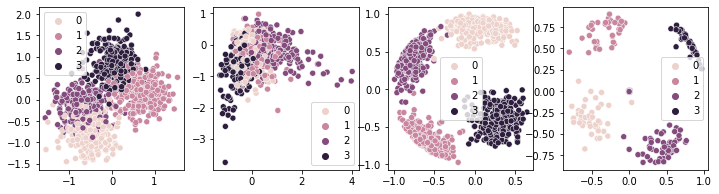

In [7]:
K=4
P=1000
N=3
num_sub=1
arrange = ar.ArrangeIndependent(K=K, P=P, spatial_specific=False, remove_redundancy=False)


emissionGMM = em.MixGaussian(K=K, N=N, P=P)
emissionGMM.sigma2 = pt.tensor(0.1)
emissionGME = em.MixGaussianExp(K=K,N=N,P=P)
emissionGME.sigma2 = pt.tensor(0.1)
emissionVMF = em.MixVMF(K=K,N=N,P=P)
emissionVMF.kappa = pt.tensor(30)
emissionwVMF = em.wMixVMF(K=K,N=N,P=P)
emissionwVMF.kappa = pt.tensor(30)

# Step 1: Generate data by sampling from the above model
U = arrange.sample(num_subj=1)
Y1 = emissionGMM.sample(U)
Y2 = emissionGME.sample(U)
Y3 = emissionVMF.sample(U)
Y4 = emissionwVMF.sample(U)
Y=[]
Y.append(Y1)
Y.append(Y2)
Y.append(Y3)
Y.append(Y4)

plt.figure(figsize=(12,3))
for i in range(4): 
    plt.subplot(1,4,i+1)
    sb.scatterplot(x=Y[i][0,0,:],y=Y[i][0,1,:],hue=U[0]) 


In [ ]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

fig = make_subplots(rows=1, cols=4, specs=[[{'type': 'surface'}, {'type': 'surface'}, 
                                           {'type': 'surface'}, {'type': 'surface'}]],
                    subplot_titles=["GMM", "GME", "VMF", "wVMF"])

fig.add_trace(go.Scatter3d(x=Y1[0, 0, :], y=Y1[0, 1, :], z=Y1[0, 2, :],
                           mode='markers', marker=dict(size=3, opacity=0.7, color=U[0])), row=1, col=1)
fig.add_trace(go.Scatter3d(x=Y2[0, 0, :], y=Y2[0, 1, :], z=Y2[0, 2, :],
                           mode='markers', marker=dict(size=3, opacity=0.7, color=U[0])), row=1, col=2)
fig.add_trace(go.Scatter3d(x=Y3[0, 0, :], y=Y3[0, 1, :], z=Y3[0, 2, :],
                           mode='markers', marker=dict(size=3, opacity=0.7, color=U[0])), row=1, col=3)
fig.add_trace(go.Scatter3d(x=Y4[0, 0, :], y=Y4[0, 1, :], z=Y4[0, 2, :],
                           mode='markers', marker=dict(size=3, opacity=0.7, color=U[0])), row=1, col=4)

fig.update_layout(title_text='Visualization of data generation')
fig.show()

## Fitting model using generated data

Here we will fit the three emission model by given the true generated data from each model. Since the main propose is to test the emission models standalone, we freeze the arrangement model to use `Independent arrangement model` for all model fitting. It means each brain location has no spatial relations with nearby or all other location. 


### 1. Fitting GMM

The testing process for each of the emission model is quiet similar as shown below. First, we initialize the true arrangement model and emission model with the true parameters. Secondly, we generate the true data from the true model, then compute the true emission log-likelihood for later use. Thirdly, we create another arrangement/emission model for data fitting. Lastly, we run EM algorithm for optimizing the model parameters.

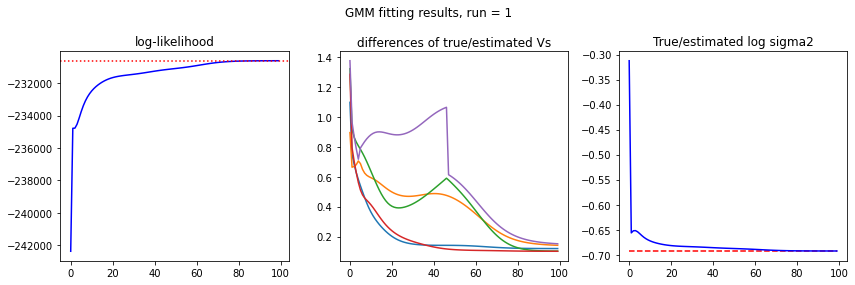

Done simulation GMM.


In [5]:
from test_emissions import _simulate_full_GMM, _simulate_full_GME, _simulate_full_VMF, _simulate_full_GMM_from_VMF

_simulate_full_GMM(X=None, K=5, P=1000, N=20, num_sub=10, max_iter=100,sigma2=0.5)

Here, we plot the curve of emission log-likelihood by iterations. We also plot the difference (distance) between the true Vs and the estimated Vs in the upper figure, and plot the true sigma vs. the estimated signma square at the bottom figure.

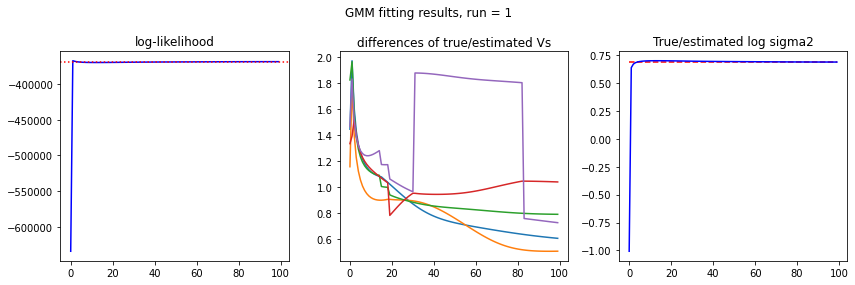

Done simulation GMM.


In [6]:
_simulate_full_GMM(X=None, K=5, P=1000, N=20, num_sub=10, max_iter=100, sigma2=2.0)

**TO DO**: The GMM model fitting shows a decreasing log-likelihood when the training data is noisy (higher sigma squared). Not sure how this problem happened, need to be sloved. 

### 2. Fitting VMF


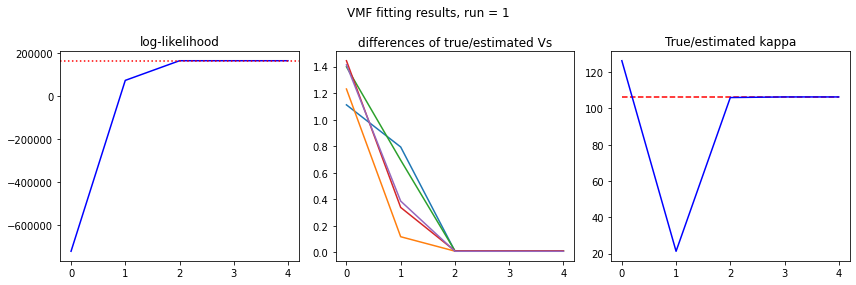

Done simulation VMF.


In [7]:
_simulate_full_VMF(X=None, K=5, P=1000, N=20, num_sub=10, max_iter=100, uniform_kappa=True)

**Explanation why GMM cannot fit VMF data:** Here we use the data generated from a VMF model with an random exponential signal strength for each brain location to fit a GMM model. Below is the result, and we can clearly see the GMM failed to clustering the signal into one cloud, instead it clusters the noise in the middle and signals separately.

In [8]:
_simulate_full_GMM_from_VMF(K=5, P=1000, N=3, num_sub=10, max_iter=100, beta=0.5)

Done simulation GMM from VMF.


### 3. Fitting GMM_exp



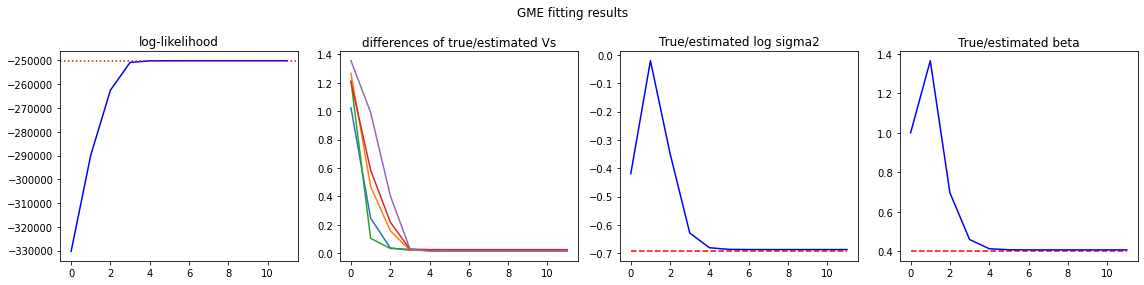

Done simulation GME.


In [14]:
_simulate_full_GME(X=None, K=5, P=1000, N=20, num_sub=10, max_iter=100, type_estep='linspace',num_bins=100,beta=0.4,sigma2=0.5)

**TO DO**: Again, the GME model fitting does not work properly when the training data is noisy (higher sigma squared, low scale factor of exponential (1/beta)). Not sure how this problem happened, need to be sloved. 

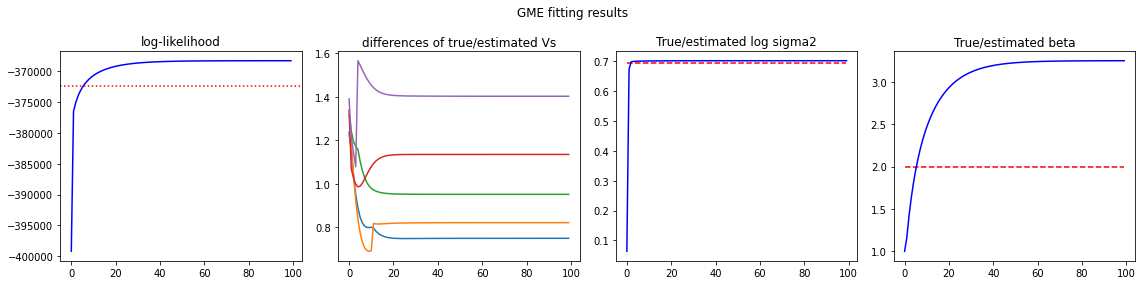

Done simulation GME.


In [18]:
_simulate_full_GME(X=None, K=5, P=1000, N=20, num_sub=10, max_iter=100, type_estep='linspace', num_bins=100, beta=2.0, sigma2=2.0)

#### Parameters recovery from different sampling methods in E_step

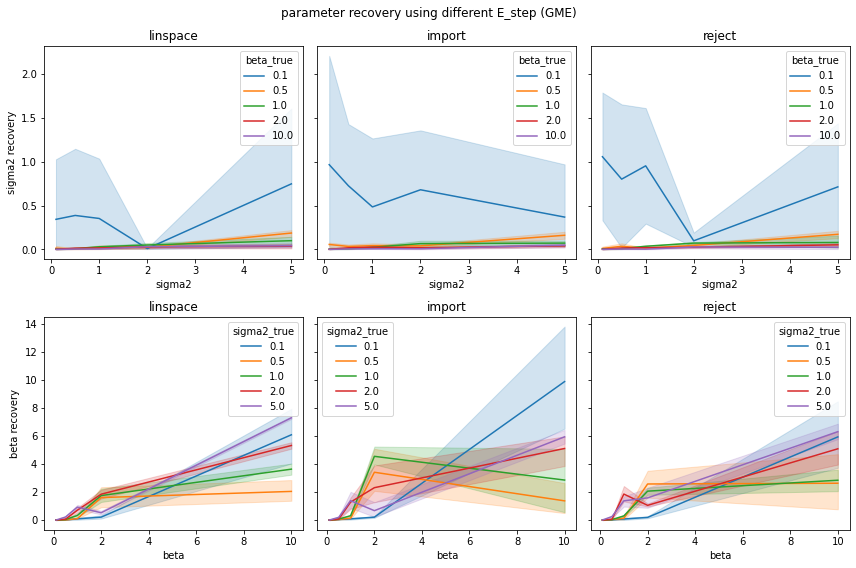

In [13]:
from test_emissions import _param_recovery_GME, plot_comparison_samplingGME

T = _param_recovery_GME(K=5, P=200, N=20, num_sub=5, max_iter=100, num_bins=300,
                            std_V=True, num_iter=5, sigma2=[0.1, 0.5, 1.0, 2.0, 5.0], beta=[0.1, 0.5, 1.0, 2.0, 10.0],
                            type_estep=['linspace', 'import', 'reject'])
plot_comparison_samplingGME(T, type_estep=['linspace', 'import', 'reject'])

In each plot of above figure, the y-axis is the difference between the true parameter and the predicted parameter. The first row is to show the parameter recovery of sigma squared using different E step methods. We can see that the performance of three methods recovery for sigma2 is relatively good in different signal strength (beta), expect when beta=0.1 (mean signal strength is 10). On the contrary, the second row indicates the parameter recovery for beta. It is hard to tell which method is the best among the three. Visually, linspace and rejection sampling have overall lower recovery error, while importance sampling shows better recovery ability when sigma2=0.5 and 1. So in the following model recovery simulation, we keep to use the `linspace` as our primary sampling method for the E_step in GME model.

## Model recovery simulations 

Here we will fit the three emission model by given the true generated data from each model. Since the main propose is to test the emission models standalone, we freeze the arrangement model to use `Independent arrangement model` for all model fitting. It means each brain location has no spatial relations with nearby or all other location. 

The true training data $Y_{train}$ were generated by using the three models separately, and a test set $Y_{test}$ was also generated using the same true model and Us along with the training data. We then fit all three emission models using those three training data set. Then, we inferred $\hat{U}$ on the training data using the fitted model to compare with the true $U$, or cross validate with the $Y_{test}$.

Several evaluation metric were provided in our `READ.me` file, including both $U$ - $\hat{U}$ comparison (such as `absolute error`, `Normalized Mutual Information (NMI)`, `Adjusted Rand Index (ARI)`, etc.) and $Y_{test}$ - $\hat{U}$ evaluation (such as the `cosine error` and `MSE`).

### Results on training dataset (K = 5)

In [2]:
from test_emissions import do_full_comparison_emission, plot_comparision_emission
import pandas as pd

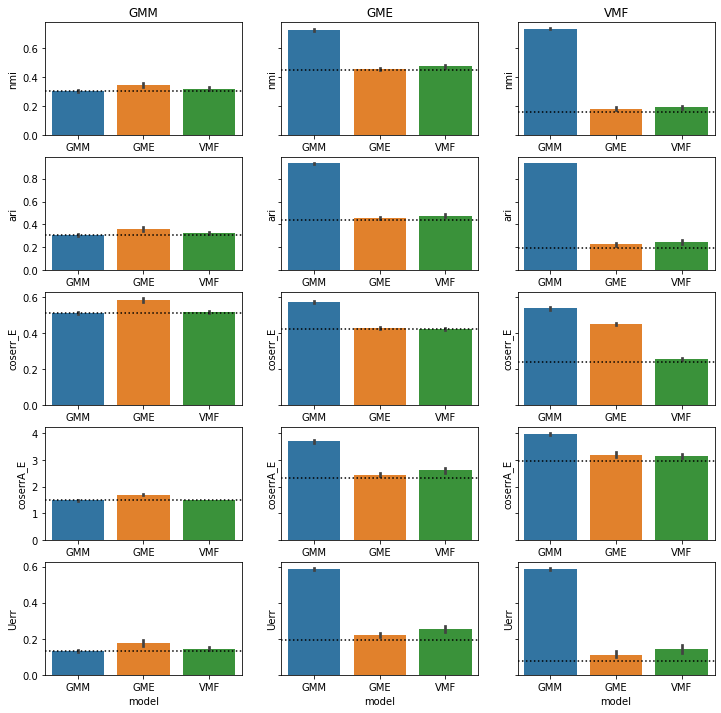

In [20]:
T=do_full_comparison_emission(clusters=5, iters=100, beta=0.4, true_models = ['GMM','GME','VMF'],
                              disper = [0.1,0.1,50], same_signal=True)

plot_comparision_emission(T)
T.to_csv('emission_modelrecover_k5_iter100.csv')

In [22]:
T = pd.read_csv('emission_modelrecover_k5_iter100.csv')

# Pair-wise ttest between GME and VMF
ind_GME2GME = (T.data_type == 'GME') & (T.model != 'true') & (T.model == 'GME')
ind_GME2VMF = (T.data_type == 'GME') & (T.model != 'true') & (T.model == 'VMF')

ind_VMF2VMF = (T.data_type == 'VMF') & (T.model != 'true') & (T.model == 'VMF')
ind_VMF2GME = (T.data_type == 'VMF') & (T.model != 'true') & (T.model == 'GME')

import scipy.stats as spst

# First ttest on U_error and adjusted weighted cosine error, data generated from GME model
print(spst.ttest_rel(T[ind_GME2GME]['Uerr'].values, T[ind_GME2VMF]['Uerr'].values))
print(spst.ttest_rel(T[ind_GME2GME]['coserrA_E'].values, T[ind_GME2VMF]['coserrA_E'].values))

# Second ttest on U_error and adjusted weighted cosine error, data generated from VMF model
print(spst.ttest_rel(T[ind_VMF2VMF]['Uerr'].values, T[ind_GME2VMF]['Uerr'].values))
print(spst.ttest_rel(T[ind_VMF2GME]['coserrA_E'].values, T[ind_GME2VMF]['coserrA_E'].values))

Ttest_relResult(statistic=-3.0439891682615055, pvalue=0.002990503961727418)
Ttest_relResult(statistic=-2.7481995742327356, pvalue=0.007122030643003786)
Ttest_relResult(statistic=-7.028555905193738, pvalue=2.700974787188403e-10)
Ttest_relResult(statistic=8.427420795910306, pvalue=2.8892876729120813e-13)


### Results on training dataset (K = 10)

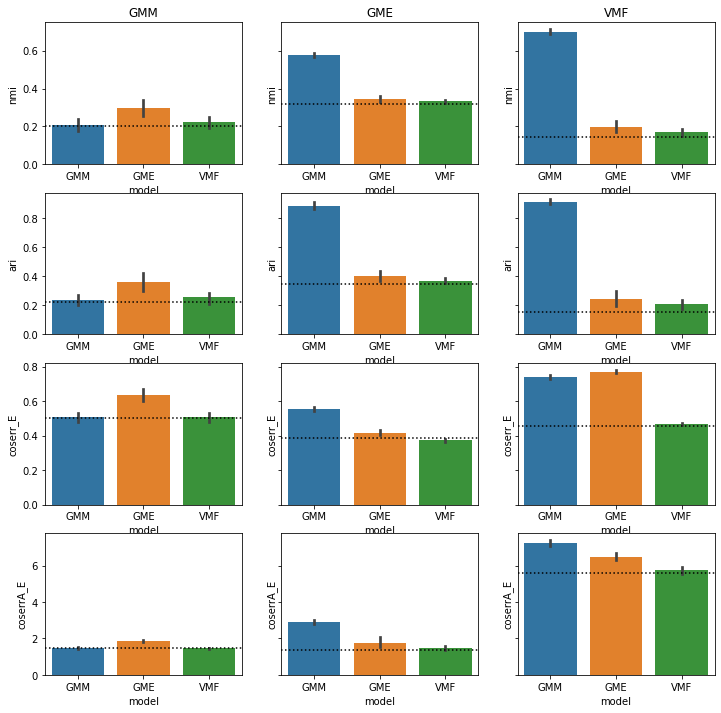

In [9]:
T=do_full_comparison_emission(clusters=10, iters=10, beta=0.4, true_models = ['GMM','GME','VMF'],
                              disper = [0.1,0.1,18], same_signal=True)

plot_comparision_emission(T)
T.to_csv('emission_modelrecover_k10.csv')

### Results on training dataset (K = 20)

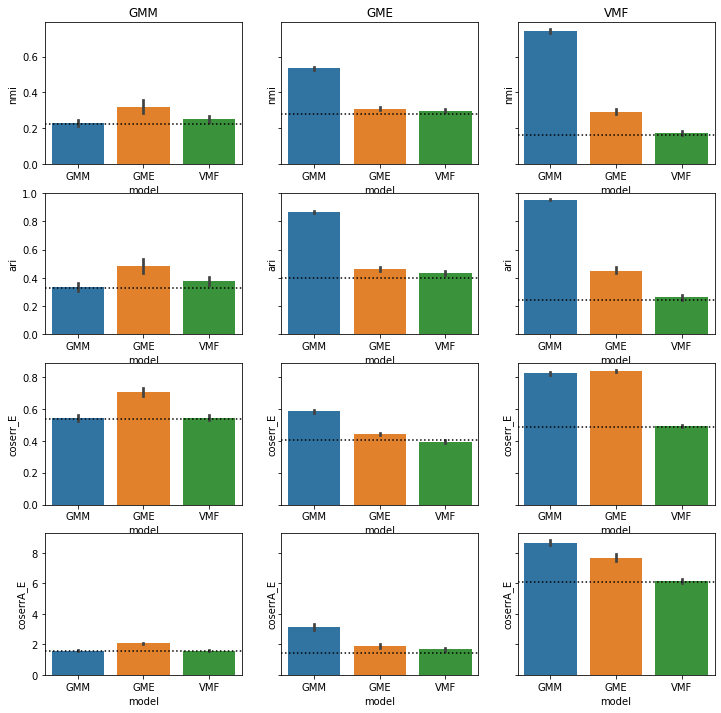

In [10]:
T=do_full_comparison_emission(clusters=20, iters=10, beta=0.4, true_models = ['GMM','GME','VMF'],
                              disper = [0.1,0.1,18], same_signal=True)

plot_comparision_emission(T)
T.to_csv('emission_modelrecover_k20.csv')

### Results on training dataset (K = 50)

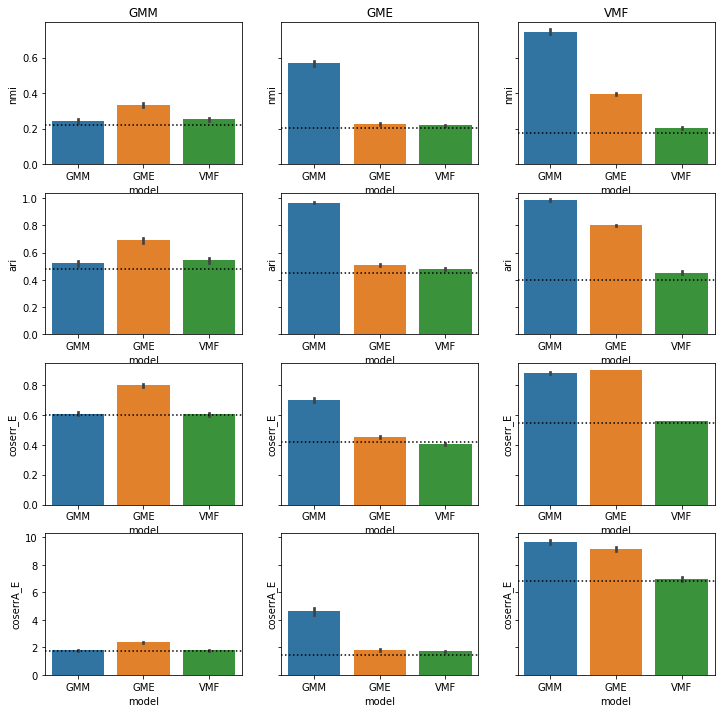

In [11]:
T=do_full_comparison_emission(clusters=50, iters=10, beta=0.4, true_models = ['GMM','GME','VMF'],
                              disper = [0.1,0.1,18], same_signal=True)

plot_comparision_emission(T)
T.to_csv('emission_modelrecover_k50.csv')

### Results on training dataset (K = 5, same_signal= False)

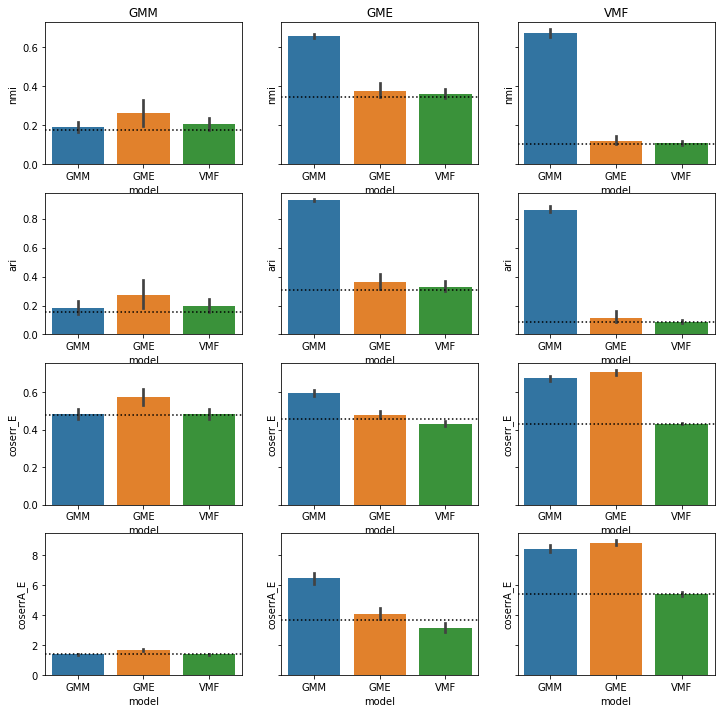

In [12]:
T=do_full_comparison_emission(clusters=5, iters=10, beta=0.4, true_models = ['GMM','GME','VMF'],
                              disper = [0.1,0.1,18], same_signal=False)

plot_comparision_emission(T)
T.to_csv('emission_modelrecover_k5signal0.csv')

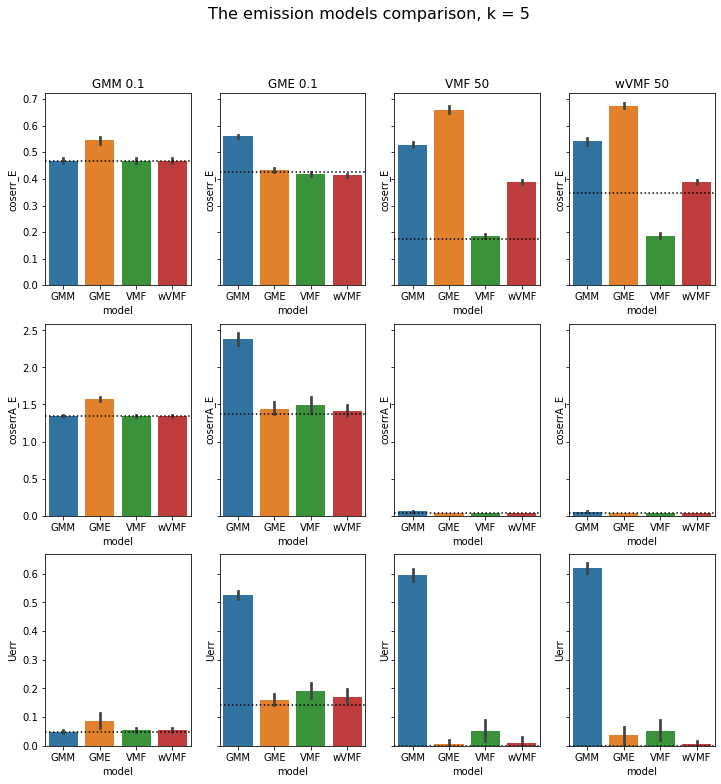

In [6]:
K=5
# T = do_full_comparison_emission(clusters=K, iters=50, beta=0.5,
#                                     true_models=['GMM', 'GME', 'VMF', 'wVMF'],
#                                     disper=[0.1, 0.1, 50, 50], same_signal=True, missingdata=None)

T = pd.read_csv('vmf_wvmf_k5iter50.csv')
plot_comparision_emission(T, K=K, dispersion=[0.1, 0.1, 50, 50])


In [8]:
from test_emissions import getData_from_T
import scipy.stats as spst

D1 = getData_from_T(T, crit='Uerr', true_model='VMF', fit_model=['VMF', 'wVMF'], trim_locmin=False)
print(D1[0].mean(), D1[1].mean(), spst.ttest_rel(D1[0], D1[1]))

D2 = getData_from_T(T, crit='Uerr', true_model='wVMF', fit_model=['VMF', 'wVMF'], trim_locmin=False)
print(D2[0].mean(), D2[1].mean(), spst.ttest_rel(D2[0], D2[1]))

0.052306 0.009962 Ttest_relResult(statistic=2.4041781514928346, pvalue=0.020034848256959052)
0.05191 0.005097999999999999 Ttest_relResult(statistic=2.4227937841735367, pvalue=0.0191434310246672)
